1.  Попробуйте обучить нейронную сеть YOLOv3 из ImageAI на любом датасете. Можете взять один из этих наборов данных:
- [https://www.kaggle.com/sshikamaru/car-object-detection](https://www.kaggle.com/sshikamaru/car-object-detection)
2. *Сделайте краткий обзор какой-нибудь научной работы, посвященной алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from PIL import ImageDraw, ImageColor, ImageFont, Image

import os 

import shutil
import cv2

from tqdm import tqdm
from imageai.Detection.Custom import DetectionModelTrainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
train = pd.read_csv(r'/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')
train.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [4]:
train_image_root_path = Path('/content/drive/MyDrive/data/training_images')

In [6]:
train['res'] = train['image'].apply(lambda x: cv2.imread(f'/content/drive/MyDrive/data/training_images/{x}').shape)
train.res.unique()


array([(380, 676, 3)], dtype=object)

Все картинки одинакового разрешения. Это хорошо.

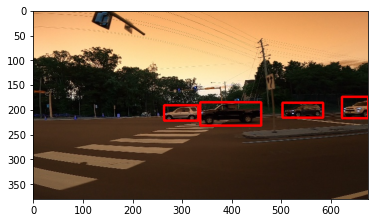

In [7]:
row = train.sample()

img = cv2.imread(f'/content/drive/MyDrive/data/training_images/{row.image.values[0]}')

for idx in train.loc[train['image'] == row.image.values[0]].index:
    xmin = train.iloc[[idx]].xmin.values[0]
    ymin = train.iloc[[idx]].ymin.values[0]
    xmax = train.iloc[[idx]].xmax.values[0]
    ymax = train.iloc[[idx]].ymax.values[0]

    img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=(255, 0, 0), thickness=4)
plt.imshow(img)
plt.show()

In [ ]:
def indent(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i

In [ ]:
# os.mkdir('./data')

def create_paths(root_path = Path('./data/')):
    data_path = root_path
    path_to_train = data_path / Path('train')
    path_to_validation = data_path / Path('validation')
    os.mkdir(path_to_train)
    os.mkdir(path_to_validation)

    path_to_train_images = path_to_train / Path('images')
    path_to_train_annotations = path_to_train / Path('annotations')
    os.mkdir(path_to_train_images)
    os.mkdir(path_to_train_annotations)


    path_to_validation_images = path_to_validation / Path('images')
    path_to_validation_annotations = path_to_validation / Path('annotations')
    os.mkdir(path_to_validation_images)
    os.mkdir(path_to_validation_annotations)
    
    return path_to_train_images, path_to_train_annotations, path_to_validation_images, path_to_validation_annotations

In [ ]:
def data_preprocession(data: pd.DataFrame, make_directory_tree=True):

    train_precent = .8
    train_indx = int(data.shape[0] * train_precent) 
    
    if make_directory_tree:
        path_to_train_images, path_to_train_annotations, path_to_validation_images, path_to_validation_annotations = create_paths()

    for i in tqdm(range(data.shape[0])):

        if i <= train_indx:
            current_path_to_image = path_to_train_images
            current_path_to_annotation = path_to_train_annotations
        else:
            current_path_to_image = path_to_validation_images
            current_path_to_annotation = path_to_validation_annotations

        path_to_img = train_image_root_path / Path(data.iloc[i].image)

        shutil.copy(path_to_img, current_path_to_image)

        xml_file_name = path_to_img.name[:-len(path_to_img.suffix)] + '.xml'
        create_annotation(path_to_img, 
                          current_path_to_annotation / xml_file_name, 
                          xmin=data.iloc[i].xmin, 
                          ymin=data.iloc[i].ymin, 
                          xmax=data.iloc[i].xmax, 
                          ymax=data.iloc[i].ymax)

In [ ]:
data_preprocession(train, make_directory_tree=True)

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'data\\train'

In [10]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory='/content/drive/MyDrive/data')
trainer.setTrainConfig(object_names_array=['car'], 
                       batch_size=10, 
                       num_experiments=20, 
                       train_from_pretrained_model='/content/drive/MyDrive/yolov3/pretrained-yolov3.h5')

trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.85
Anchor Boxes generated.
Detection configuration saved in  /content/drive/MyDrive/data/json/detection_config.json
Evaluating over 77 samples taken from /content/drive/MyDrive/data/validation
Training over 278 samples  given at /content/drive/MyDrive/data/train
Training on: 	['car']
Training with Batch Size:  10
Number of Training Samples:  278
Number of Validation Samples:  77
Number of Experiments:  20
Training with transfer learning from pretrained Model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
224/224 [==============================] - 402s 2s/step - loss: 105.7075 - yolo_layer_3_loss: 14.3381 - yolo_layer_4_loss: 22.7602 - yolo_layer_5_loss: 57.0422 - val_loss: 40.3830 - val_yolo_layer_3_loss: 2.8833 - val_yolo_layer_4_loss: 10.3181 - val_yolo_layer_5_loss: 15.7655
Epoch 2/20
224/224 [==============================] - 370s 2s/step - loss: 33.6063 - yolo_layer_3_loss: 5.1125 - yolo_layer_4_loss: 6.4637 - yolo_layer_5_loss: 10.7679 - val_loss: 32.7889 - val_yolo_layer_3_loss: 2.9373 - val_yolo_layer_4_loss: 8.3149 - val_yolo_layer_5_loss: 11.0989
Epoch 3/20
224/224 [==============================] - 372s 2s/step - loss: 26.3986 - yolo_layer_3_loss: 4.3176 - yolo_layer_4_loss: 5.4976 - yolo_layer_5_loss: 6.7799 - val_loss: 24.3645 - val_yolo_layer_3_loss: 3.4821 - val_yolo_layer_4_loss: 5.1857 - val_yolo_layer_5_loss: 7.1553
Epoch 4/20
224/224 [==============================] - 368s 2s/step - loss: 23.7525 - yolo_layer_3_loss: 4.4268 - yolo_layer_4_loss: 5.0271 - yo

In [11]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory='/content/drive/MyDrive/data')
metrics = trainer.evaluateModel(model_path='/content/drive/MyDrive/data/models/detection_model-ex-015--loss-0015.821.h5',
                                json_path='/content/drive/MyDrive/data/json/detection_config.json',
                                iou_threshold=0.2,
                                object_threshold=0.3,
                                nms_threshold=0.5)

Starting Model evaluation....
Evaluating over 77 samples taken from /content/drive/MyDrive/data/validation
Training over 278 samples  given at /content/drive/MyDrive/data/train
Model File:  /content/drive/MyDrive/data/models/detection_model-ex-015--loss-0015.821.h5 

Evaluation samples:  77
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
car: 0.7075
mAP: 0.7075


In [24]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath('/content/drive/MyDrive/data/models/detection_model-ex-015--loss-0015.821.h5')
detector.setJsonPath('/content/drive/MyDrive/data/json/detection_config.json')
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=40,
                                             input_image='/content/drive/MyDrive/data/validation/images/vid_4_8560.jpg',
                                             output_image_path="detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


car  :  48.73017966747284  :  [183, 192, 290, 226]


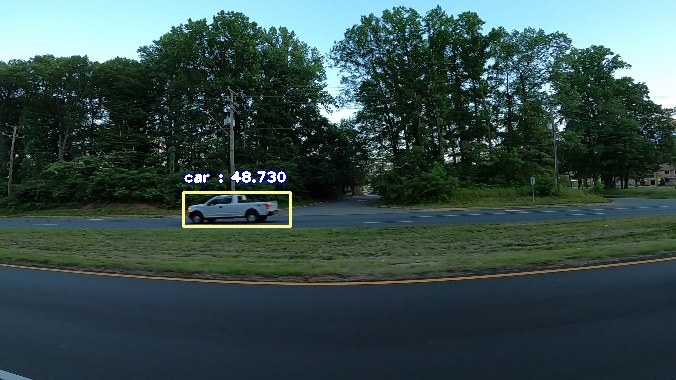

In [25]:
from PIL import Image
Image.open('/content/detected.jpg')